NECESSARY IMPORTS

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [ ]:
pip install albumentations

In [ ]:
from google.colab import drive
import os
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import math
import shutil
from tqdm import tqdm
import pandas as pd
import numpy as np
# import albumentations as A

DATA AUGMENTATION


In [ ]:
modalities = ['BLI', 'FICE', 'LCI', 'NBI', 'WLI']
for modality in modalities:
  print(f'No of images, masks in {modality}: ' , len(os.listdir(f'/content/drive/MyDrive/Balanced_Dataset/{modality}/images')), len(os.listdir(f'/content/drive/MyDrive/Balanced_Dataset/{modality}/masks')))

No of images, masks in BLI:  600 600
No of images, masks in FICE:  600 600
No of images, masks in LCI:  600 600
No of images, masks in NBI:  600 600
No of images, masks in WLI:  600 600


augmenting-> bli, fice, lci and nbi to 600 images total.

In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A

def augment_modality(modality_name, target_count):
    base_path = "/content/drive/MyDrive/Balanced_Dataset"
    save_path = "/content/drive/MyDrive/Balanced_Dataset"

    img_dir = os.path.join(base_path, modality_name, "images")
    mask_dir = os.path.join(base_path, modality_name, "masks")
    save_img_dir = os.path.join(save_path, modality_name, "images")
    save_mask_dir = os.path.join(save_path, modality_name, "masks")

    os.makedirs(save_img_dir, exist_ok=True)
    os.makedirs(save_mask_dir, exist_ok=True)

    # Get filenames using pandas
    image_files = pd.Series(os.listdir(img_dir))
    image_files = image_files[image_files.str.endswith(".jpg")]
    df = pd.DataFrame({"img": image_files})
    df["name"] = df["img"].str.replace(".jpg", "", regex=False)
    df["mask"] = df["name"] + "_mask.jpg"

    current_count = len(df)
    needed = target_count - current_count
    if needed <= 0:
        print(f"✅ {modality_name} already has {current_count} images.")
        return

    print(f"\n📂 Modality: {modality_name}")
    print(f"Current: {current_count}, Target: {target_count}, Augmenting: {needed}")

    multiplier = int(np.ceil(needed / current_count))
    total_augmented = 0

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        # A.RandomBrightnessContrast(p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
        A.GridDistortion(p=0.2),
        # A.HueSaturationValue(p=0.3)
    ])

    for _, row in tqdm(df.iterrows(), total=current_count, desc=f"Augmenting {modality_name}"):
        img_path = os.path.join(img_dir, row["img"])
        mask_path = os.path.join(mask_dir, row["mask"])

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Ensure same height and width
        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)


        # # Save original image and mask
        # shutil.copy2(img_path, os.path.join(save_img_dir, row["img"]))
        # shutil.copy2(mask_path, os.path.join(save_mask_dir, row["mask"]))

        for i in range(multiplier):
            if total_augmented >= needed:
                break

            augmented = transform(image=img, mask=mask)
            aug_img = augmented["image"]
            aug_mask = augmented["mask"]

            aug_img_name = f"{row['name']}_aug{i}.jpg"
            aug_mask_name = f"{row['name']}_aug{i}_mask.jpg"

            cv2.imwrite(os.path.join(save_img_dir, aug_img_name), aug_img)
            cv2.imwrite(os.path.join(save_mask_dir, aug_mask_name), aug_mask)

            total_augmented += 1

    print(f"✅ Done: {modality_name} — Augmented {total_augmented} images\n")


In [ ]:
augment_modality("BLI", 600)
augment_modality("FICE", 600)
augment_modality("LCI", 600)
augment_modality("NBI", 600)


selecting 600 wli images and storing the rest in a separate folder

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm

def split_wli_images(source_dir, target_dir, num_samples=600):
    img_dir = os.path.join(source_dir, "WLI", "images")
    mask_dir = os.path.join(source_dir, "WLI", "masks")

    target_img_dir = os.path.join(target_dir, "WLI", "images")
    target_mask_dir = os.path.join(target_dir, "WLI", "masks")
    unused_img_dir = os.path.join(target_dir, "WLI_unused", "images")
    unused_mask_dir = os.path.join(target_dir, "WLI_unused", "masks")

    os.makedirs(target_img_dir, exist_ok=True)
    os.makedirs(target_mask_dir, exist_ok=True)
    os.makedirs(unused_img_dir, exist_ok=True)
    os.makedirs(unused_mask_dir, exist_ok=True)

    all_images = pd.Series(os.listdir(img_dir))
    all_images = all_images[all_images.str.endswith(".jpg")]

    selected_images = all_images.sample(n=num_samples, random_state=42).reset_index(drop=True)
    unused_images = all_images[~all_images.isin(selected_images)].reset_index(drop=True)

    print(f"\n📂 Copying {num_samples} selected WLI images to Balanced_Dataset...")
    for img_name in tqdm(selected_images, desc="Selected WLI"):
        mask_name = img_name.replace(".jpg", "_mask.jpg")
        shutil.copy2(os.path.join(img_dir, img_name), os.path.join(target_img_dir, img_name))
        shutil.copy2(os.path.join(mask_dir, mask_name), os.path.join(target_mask_dir, mask_name))

    print(f"\n📂 Copying {len(unused_images)} unused WLI images to WLI_unused...")
    for img_name in tqdm(unused_images, desc="Unused WLI"):
        mask_name = img_name.replace(".jpg", "_mask.jpg")
        shutil.copy2(os.path.join(img_dir, img_name), os.path.join(unused_img_dir, img_name))
        shutil.copy2(os.path.join(mask_dir, mask_name), os.path.join(unused_mask_dir, mask_name))

    print("\n✅ Done with WLI selection and separation.")

split_wli_images(
    source_dir="/content/drive/MyDrive/polypDB",
    target_dir="/content/drive/MyDrive/Balanced_Dataset",
    num_samples=600
)



📂 Copying 600 selected WLI images to Balanced_Dataset...


Selected WLI: 100%|██████████| 600/600 [00:18<00:00, 33.07it/s]



📂 Copying 2988 unused WLI images to WLI_unused...


Unused WLI: 100%|██████████| 2988/2988 [01:33<00:00, 31.89it/s]


✅ Done with WLI selection and separation.


TRAIN TEST VAL SPLIT; split the dataset and saved the names of the files into train test and val folder

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def create_split_files(base_dir, modalities, seed=42):
    # Create directories for train, val, test
    split_dirs = ["train", "val", "test"]
    for split_dir in split_dirs:
        os.makedirs(os.path.join(base_dir, split_dir), exist_ok=True)

    for modality in modalities:
        print(f"🔄 Processing {modality}...")

        # Directories for images and masks
        img_dir = os.path.join(base_dir, modality, "images")
        mask_dir = os.path.join(base_dir, modality, "masks")

        # Get all image filenames
        image_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

        # Create DataFrame for easy processing
        data = pd.DataFrame({
            'image': image_files,
            'mask': [f"{img.replace('.jpg', '_mask.jpg')}" for img in image_files]
        })

        # Shuffle data using numpy
        data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

        # Split data: 80% train, 10% val, 10% test
        train_data, temp_data = train_test_split(data, test_size=0.2, random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=seed)

        # Convert DataFrames to lists of strings for saving
        def save_split(split_name, data_df):
            file_path = os.path.join(base_dir, split_name, f"{split_name}_{modality}.txt")
            data_list = data_df.apply(lambda row: f"{modality}/images/{row['image']},{modality}/masks/{row['mask']}", axis=1).tolist()
            with open(file_path, 'w') as f:
                f.write('\n'.join(data_list))
            print(f"✅ {split_name}_{modality}.txt saved with {len(data_list)} entries.")

        # Save splits to text files
        save_split("train", train_data)
        save_split("val", val_data)
        save_split("test", test_data)

# Example usage
create_split_files(
    base_dir="/content/drive/MyDrive/Balanced_Dataset",  # Adjust the path as needed
    modalities=["WLI", "NBI", "BLI", "FICE", "LCI"]  # List all modalities
)


🔄 Processing WLI...
✅ train_WLI.txt saved with 480 entries.
✅ val_WLI.txt saved with 60 entries.
✅ test_WLI.txt saved with 60 entries.
🔄 Processing NBI...
✅ train_NBI.txt saved with 480 entries.
✅ val_NBI.txt saved with 60 entries.
✅ test_NBI.txt saved with 60 entries.
🔄 Processing BLI...
✅ train_BLI.txt saved with 480 entries.
✅ val_BLI.txt saved with 60 entries.
✅ test_BLI.txt saved with 60 entries.
🔄 Processing FICE...
✅ train_FICE.txt saved with 480 entries.
✅ val_FICE.txt saved with 60 entries.
✅ test_FICE.txt saved with 60 entries.
🔄 Processing LCI...
✅ train_LCI.txt saved with 480 entries.
✅ val_LCI.txt saved with 60 entries.
✅ test_LCI.txt saved with 60 entries.


For each modality:

1. Resize image + mask (say to 256x256 or 128x128).
2. Normalize image.
3. Convert mask to binary.
4. Save both as .npy.

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Resize target
RESIZE_SHAPE = (256, 256)

# Input modalities
modalities = [
    "/content/drive/MyDrive/Balanced_Dataset/WLI",
    "/content/drive/MyDrive/Balanced_Dataset/LCI",
    "/content/drive/MyDrive/Balanced_Dataset/FICE",
    "/content/drive/MyDrive/Balanced_Dataset/NBI",
    "/content/drive/MyDrive/Balanced_Dataset/BLI",
]

def process_modality(modality_path):
    image_dir = os.path.join(modality_path, "images")
    mask_dir = os.path.join(modality_path, "masks")
    npy_image_dir = os.path.join(modality_path, "npy_files", "images")
    npy_mask_dir = os.path.join(modality_path, "npy_files", "masks")

    os.makedirs(npy_image_dir, exist_ok=True)
    os.makedirs(npy_mask_dir, exist_ok=True)

    image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg") and "_mask" not in f]

    for img_file in tqdm(image_files, desc=f"Processing {os.path.basename(modality_path)}"):
        img_path = os.path.join(image_dir, img_file)
        mask_file = img_file.replace(".jpg", "_mask.jpg")
        mask_path = os.path.join(mask_dir, mask_file)

        if not os.path.exists(mask_path):
            continue

        # Load and resize image
        image = cv2.imread(img_path)
        image = cv2.resize(image, RESIZE_SHAPE)
        image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Load and resize mask (use INTER_NEAREST for binary masks)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, RESIZE_SHAPE, interpolation=cv2.INTER_NEAREST)

        # Convert to binary mask (strict 0 or 1)
        _, binary_mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        # Save as .npy
        np.save(os.path.join(npy_image_dir, img_file.replace(".jpg", ".npy")), image)
        np.save(os.path.join(npy_mask_dir, mask_file.replace(".jpg", ".npy")), binary_mask)

# Run for all modalities
for mod_path in modalities:
    process_modality(mod_path)


Processing BLI: 100%|██████████| 600/600 [04:27<00:00,  2.24it/s]


Save the 4 coordinates to csv file

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# # Paths to the modalities
# modalities = [
#     "/content/drive/MyDrive/Balanced_Dataset/WLI",
#     "/content/drive/MyDrive/Balanced_Dataset/LCI",
#     "/content/drive/MyDrive/Balanced_Dataset/FICE",
#     "/content/drive/MyDrive/Balanced_Dataset/NBI",
#     "/content/drive/MyDrive/Balanced_Dataset/BLI",
# ]

# # Output directory for CSVs
# output_dir = "/content/drive/MyDrive/Balanced_Dataset/bounding_boxes"
# os.makedirs(output_dir, exist_ok=True)

# def get_bounding_box(mask):
#     y_indices, x_indices = np.where(mask > 0)
#     if len(x_indices) == 0 or len(y_indices) == 0:
#         return None
#     return [int(x_indices.min()), int(y_indices.min()), int(x_indices.max()), int(y_indices.max())]

# # Process each modality
# for modality_path in modalities:
#     modality_name = os.path.basename(modality_path)
#     mask_dir = os.path.join(modality_path, "npy_files", "masks")  # Masks are in 'npy_files/masks'
#     bbox_data = []

#     for file_name in tqdm(os.listdir(mask_dir), desc=f"Processing {modality_name}"):
#         if not file_name.endswith(".npy"):
#             continue
#         mask_path = os.path.join(mask_dir, file_name)
#         mask = np.load(mask_path)
#         bbox = get_bounding_box(mask)
#         if bbox:
#             bbox_data.append([file_name] + bbox)

#     # Save CSV for the modality
#     df = pd.DataFrame(bbox_data, columns=["image_name", "x_min", "y_min", "x_max", "y_max"])
#     csv_path = os.path.join(output_dir, f"{modality_name}_bboxes.csv")
#     df.to_csv(csv_path, index=False)

# output_dir  # Show output folder path for reference



# #################################### MODIFIED TO HANDLE MULTIPLE TUMORS
# ##################################### i.e. TO GENERATE MUTIPLE ENTRIES FOR MULTIPLE TUMORS IN SAME IMAGE


import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.measure import label, regionprops

# Paths to the modalities
modalities = [
    "/content/drive/MyDrive/Balanced_Dataset/WLI",
    "/content/drive/MyDrive/Balanced_Dataset/LCI",
    "/content/drive/MyDrive/Balanced_Dataset/FICE",
    "/content/drive/MyDrive/Balanced_Dataset/NBI",
    "/content/drive/MyDrive/Balanced_Dataset/BLI",
]

# Output directory for CSVs
output_dir = "/content/drive/MyDrive/Balanced_Dataset/bounding_boxes"
os.makedirs(output_dir, exist_ok=True)

def get_bounding_boxes(mask):
    labeled_mask = label(mask)
    bounding_boxes = []
    for region in regionprops(labeled_mask):
        min_row, min_col, max_row, max_col = region.bbox
        bounding_boxes.append([min_col, min_row, max_col, max_row])
    return bounding_boxes

# Process each modality
for modality_path in modalities:
    modality_name = os.path.basename(modality_path)
    mask_dir = os.path.join(modality_path, "npy_files", "masks")  # Masks are in 'npy_files/masks'
    bbox_data = []

    for file_name in tqdm(os.listdir(mask_dir), desc=f"Processing {modality_name}"):
        if not file_name.endswith(".npy"):
            continue
        mask_path = os.path.join(mask_dir, file_name)
        mask = np.load(mask_path)
        bboxes = get_bounding_boxes(mask)
        if bboxes:
            for bbox in bboxes:
                bbox_data.append([file_name] + bbox)

    # Save CSV for the modality
    df = pd.DataFrame(bbox_data, columns=["image_name", "x_min", "y_min", "x_max", "y_max"])
    csv_path = os.path.join(output_dir, f"{modality_name}_bboxes.csv")
    df.to_csv(csv_path, index=False)

output_dir  # Show output folder path for reference

Processing BLI: 100%|██████████| 600/600 [00:16<00:00, 37.37it/s] 


'/content/drive/MyDrive/Balanced_Dataset/bounding_boxes'

VIzualize the bunding boxes

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # List of modality folders
# modalities = [
#     "/content/drive/MyDrive/Balanced_Dataset/WLI",
#     "/content/drive/MyDrive/Balanced_Dataset/LCI",
#     "/content/drive/MyDrive/Balanced_Dataset/FICE",
#     "/content/drive/MyDrive/Balanced_Dataset/NBI",
#     "/content/drive/MyDrive/Balanced_Dataset/BLI",
# ]

# # Base path for bounding box CSVs
# bbox_csv_dir = "/content/drive/MyDrive/Balanced_Dataset/bounding_boxes"

# for modality_path in modalities:
#     modality_name = os.path.basename(modality_path)
#     print(f"\n🔍 Visualizing modality: {modality_name}")

#     mask_dir = os.path.join(modality_path, "npy_files", "masks")
#     csv_path = os.path.join(bbox_csv_dir, f"{modality_name}_bboxes.csv")

#     # Load CSV
#     if not os.path.exists(csv_path):
#         print(f"⚠️ Bounding box CSV not found for {modality_name}")
#         continue
#     df = pd.read_csv(csv_path)

#     # Show only 5 random samples
#     sample_df = df.sample(min(5, len(df)), random_state=42)

#     for _, row in sample_df.iterrows():
#         file_name, x_min, y_min, x_max, y_max = row
#         mask_path = os.path.join(mask_dir, file_name)

#         # Check mask exists
#         if not os.path.exists(mask_path):
#             print(f"⚠️ Mask file missing: {mask_path}")
#             continue

#         # Load and plot
#         mask = np.load(mask_path)
#         fig, ax = plt.subplots()
#         ax.imshow(mask, cmap='gray')
#         rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
#                                  linewidth=2, edgecolor='red', facecolor='none')
#         ax.add_patch(rect)
#         ax.set_title(f"{modality_name}: {file_name}")
#         plt.axis('off')
#         plt.show()


# ############# UPDATED CODE FOR VIZUALIZATION. EARLIER CODE WAS FOR JUST ONE BOUNDING BOX,
# ############# THIS ONE SHOWS ALL THE ONES INT THE IMAGE

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# List of modality folders
modalities = [
    "/content/drive/MyDrive/Balanced_Dataset/WLI",
    "/content/drive/MyDrive/Balanced_Dataset/LCI",
    "/content/drive/MyDrive/Balanced_Dataset/FICE",
    "/content/drive/MyDrive/Balanced_Dataset/NBI",
    "/content/drive/MyDrive/Balanced_Dataset/BLI",
]

# Base path for bounding box CSVs
bbox_csv_dir = "/content/drive/MyDrive/Balanced_Dataset/bounding_boxes"

for modality_path in modalities:
    modality_name = os.path.basename(modality_path)
    print(f"\n🔍 Visualizing modality: {modality_name}")

    mask_dir = os.path.join(modality_path, "npy_files", "masks")
    csv_path = os.path.join(bbox_csv_dir, f"{modality_name}_bboxes.csv")

    # Load CSV
    if not os.path.exists(csv_path):
        print(f"⚠️ Bounding box CSV not found for {modality_name}")
        continue
    df = pd.read_csv(csv_path)

    # Group by image and pick 5 unique random images
    unique_images = df["image_name"].unique()
    sample_images = np.random.choice(unique_images, size=min(5, len(unique_images)), replace=False)

    for img_name in sample_images:
        mask_path = os.path.join(mask_dir, img_name)
        if not os.path.exists(mask_path):
            print(f"⚠️ Mask file missing: {mask_path}")
            continue

        # Load the mask
        mask = np.load(mask_path)

        # Get all bounding boxes for this image
        bboxes = df[df["image_name"] == img_name]

        # Plot the image and draw all bounding boxes
        fig, ax = plt.subplots()
        ax.imshow(mask, cmap='gray')

        for _, row in bboxes.iterrows():
            x_min, y_min, x_max, y_max = row[["x_min", "y_min", "x_max", "y_max"]]
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        ax.set_title(f"{modality_name}: {img_name} ({len(bboxes)} bounding boxes)")
        plt.axis('off')
        plt.show()


Save yolo labels from the csv generated

In [ ]:
# import os
# import pandas as pd

# # Modality to class ID mapping (alphabetical order)
# modality_to_class_id = {
#     "BLI": 0,
#     "FICE": 1,
#     "LCI": 2,
#     "NBI": 3,
#     "WLI": 4,
# }

# # Root path for bounding box CSVs and npy_files
# base_dir = "/content/drive/MyDrive/Balanced_Dataset"
# csv_dir = os.path.join(base_dir, "bounding_boxes")

# # Target YOLO label output directory
# yolo_labels_dir = os.path.join(base_dir, "yolo_labels")
# os.makedirs(yolo_labels_dir, exist_ok=True)

# # Image dimensions (since all are resized to 256x256)
# img_width = 256
# img_height = 256

# # Process each modality
# for modality, class_id in modality_to_class_id.items():
#     csv_path = os.path.join(csv_dir, f"{modality}_bboxes.csv")
#     if not os.path.exists(csv_path):
#         print(f"CSV not found for {modality}, skipping.")
#         continue

#     # Create a folder for this modality’s YOLO labels
#     label_dir = os.path.join(yolo_labels_dir, modality)
#     os.makedirs(label_dir, exist_ok=True)

#     df = pd.read_csv(csv_path)
#     for _, row in df.iterrows():
#         x_min, y_min, x_max, y_max = row[["x_min", "y_min", "x_max", "y_max"]]
#         img_name = row["image_name"]
#         yolo_name = img_name.replace("_mask.npy", ".txt")

#         # Normalize for YOLO format
#         x_center = ((x_min + x_max) / 2) / img_width
#         y_center = ((y_min + y_max) / 2) / img_height
#         box_width = (x_max - x_min) / img_width
#         box_height = (y_max - y_min) / img_height

#         yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n"

#         # Save label
#         label_path = os.path.join(label_dir, yolo_name)
#         with open(label_path, "w") as f:
#             f.write(yolo_line)

# print("✅ YOLO label generation complete.")



#  ################ CODE TO GENERATE YOLO LABLES FOR ALL BOUNDING BOXES NOT JUST FOR ONE


import os
import numpy as np
import pandas as pd
from tqdm import tqdm
# Modality to class ID mapping (alphabetical order)
modality_to_class_id = {
    "BLI": 0,
    "FICE": 1,
    "LCI": 2,
    "NBI": 3,
    "WLI": 4,
}

# Root path for bounding box CSVs and npy_files
base_dir = "/content/drive/MyDrive/Balanced_Dataset"
csv_dir = os.path.join(base_dir, "bounding_boxes")

# Target YOLO label output directory
yolo_labels_dir = os.path.join(base_dir, "yolo_labels")
os.makedirs(yolo_labels_dir, exist_ok=True)

# Image dimensions (since all are resized to 256x256)
img_width = 256
img_height = 256

# Process each modality
for modality, class_id in modality_to_class_id.items():
    csv_path = os.path.join(csv_dir, f"{modality}_bboxes.csv")
    if not os.path.exists(csv_path):
        print(f"CSV not found for {modality}, skipping.")
        continue

    # Create a folder for this modality’s YOLO labels
    label_dir = os.path.join(yolo_labels_dir, modality)
    os.makedirs(label_dir, exist_ok=True)

    df = pd.read_csv(csv_path)
    for _, row in df.iterrows():
        x_min, y_min, x_max, y_max = row[["x_min", "y_min", "x_max", "y_max"]]
        img_name = row["image_name"]
        yolo_name = img_name.replace("_mask.npy", ".txt")

        # Normalize for YOLO format
        x_center = ((x_min + x_max) / 2) / img_width
        y_center = ((y_min + y_max) / 2) / img_height
        box_width = (x_max - x_min) / img_width
        box_height = (y_max - y_min) / img_height

        yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n"

        # Save label
        label_path = os.path.join(label_dir, yolo_name)
        with open(label_path, "a") as f:  # 'a' to append multiple bounding boxes
            f.write(yolo_line)

print("✅ YOLO label generation complete.")

✅ YOLO label generation complete.


Split yolo lables into as per train test split

In [ ]:
import os
import shutil

modalities = ['BLI', 'FICE', 'LCI', 'NBI', 'WLI']
base_dir = "/content/drive/MyDrive/Balanced_Dataset"
label_input_dir = os.path.join(base_dir, "yolo_labels")
output_dir = os.path.join(base_dir, "yolo_dataset", "labels")
os.makedirs(output_dir, exist_ok = True)

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

def copy_labels(split):
    for modality in modalities:
        split_file = os.path.join(base_dir, split, f"{split}_{modality}.txt")
        if not os.path.exists(split_file):
            print(f'Not found:{split_file}')
        with open(split_file, "r") as f:
            filenames = [line.strip() for line in f]

        for line in filenames:
          image_file = line.strip().split(",")[0]
          label_name = os.path.basename(image_file).replace(".jpg", ".txt")

          src_label_path = os.path.join(label_input_dir, modality, label_name)
          dst_label_path = os.path.join(output_dir, split, label_name)

          if os.path.exists(src_label_path):
              shutil.copy(src_label_path, dst_label_path)
          else:
              print(f"⚠️ Missing label for {src_label_path}")


for split in ['train', 'val', 'test']:
    copy_labels(split)

print("✅ YOLO label organization completed.")

✅ YOLO label organization completed.


Copying images into yolo dataset for training

In [ ]:
import os
import shutil

# Root directory where all data is stored
base_dir = "/content/drive/MyDrive/Balanced_Dataset"

# Output YOLO dataset image folder structure
yolo_image_dir = os.path.join(base_dir, "yolo_dataset", "images")
splits = ["train", "val", "test"]

# Create directories if not exist
for split in splits:
    split_dir = os.path.join(yolo_image_dir, split)
    os.makedirs(split_dir, exist_ok=True)

# For each split and each modality, copy the image
for split in splits:
    split_txt_dir = os.path.join(base_dir, split)
    for file in os.listdir(split_txt_dir):
        if file.endswith(".txt"):
            with open(os.path.join(split_txt_dir, file), 'r') as f:
                lines = f.read().splitlines()
            for line in lines:
                image_path, _ = line.split(",")
                image_full_path = os.path.join(base_dir, image_path)
                image_filename = os.path.basename(image_path)
                dest_path = os.path.join(yolo_image_dir, split, image_filename)
                shutil.copy(image_full_path, dest_path)


Copying masks into yolo_dataset

In [ ]:
import os
import shutil

# Root directory where all data is stored
base_dir = "/content/drive/MyDrive/Balanced_Dataset"

# Output YOLO dataset mask folder structure
yolo_mask_dir = os.path.join(base_dir, "yolo_dataset", "masks")
splits = ["train", "val", "test"]

# Create directories if not exist
for split in splits:
    split_mask_dir = os.path.join(yolo_mask_dir, split)
    os.makedirs(split_mask_dir, exist_ok=True)

# For each split and each modality, copy the mask files
for split in splits:
    split_txt_dir = os.path.join(base_dir, split)
    for file in os.listdir(split_txt_dir):
        if file.endswith(".txt"):
            with open(os.path.join(split_txt_dir, file), 'r') as f:
                lines = f.read().splitlines()
            for line in lines:
                # Extract mask path
                _, mask_path = line.split(",")

                # Full mask path
                mask_full_path = os.path.join(base_dir, mask_path)

                # Extract mask filename
                mask_filename = os.path.basename(mask_path)

                # Destination path for the mask
                dest_mask_path = os.path.join(yolo_mask_dir, split, mask_filename)

                # Copy the mask to the YOLO dataset directory
                shutil.copy(mask_full_path, dest_mask_path)

print("Masks have been copied to the YOLO dataset structure.")


Masks have been copied to the YOLO dataset structure.


Resizing the yolo_datset images to 256,256

In [ ]:
import os
from PIL import Image
from tqdm import tqdm

# Root directory of YOLO dataset
base_dir = "/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/images"
subdirs = ["train", "val", "test"]
target_size = (256, 256)

for subdir in subdirs:
    dir_path = os.path.join(base_dir, subdir)
    for filename in tqdm(os.listdir(dir_path), desc=f"Resizing {subdir} images"):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(dir_path, filename)
            img = Image.open(img_path)
            img_resized = img.resize(target_size, Image.BILINEAR)
            img_resized.save(img_path)


Resizing test images: 100%|██████████| 300/300 [00:18<00:00, 16.52it/s]


Resizing the yolo_dataset masks

In [ ]:
import os
from PIL import Image
from tqdm import tqdm

# Root directory of YOLO dataset
base_dir = "/content/drive/MyDrive/Balanced_Dataset/yolo_dataset"
mask_subdirs = ["train", "val", "test"]
target_size = (256, 256)

# Resize masks
for subdir in mask_subdirs:
    dir_path = os.path.join(base_dir, "masks", subdir)
    for filename in tqdm(os.listdir(dir_path), desc=f"Resizing {subdir} masks"):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            mask_path = os.path.join(dir_path, filename)
            mask = Image.open(mask_path).convert("L")  # convert to grayscale
            mask_resized = mask.resize(target_size, Image.NEAREST)
            mask_resized.save(mask_path)


Resizing test masks: 100%|██████████| 300/300 [00:08<00:00, 36.91it/s]


Saving data.yaml

In [ ]:
data_yaml = """
train: /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/images/train
val: /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/images/val
test: /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/images/test

nc: 5
names: ['BLI', 'FICE', 'LCI', 'NBI', 'WLI']
"""

with open("/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/data.yaml", "w") as f:
    f.write(data_yaml.strip())


Vizualizing YOLO labels on images

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# YOLO dataset (choose train/val/test)
images_dir = "/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/images/train"
labels_dir = "/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/labels/train"

# Balanced_Dataset root (to fetch masks)
balanced_root = "/content/drive/MyDrive/Balanced_Dataset"

# Class names
class_names = ['BLI', 'FICE', 'LCI', 'NBI', 'WLI']

# List of images to visualize
image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
sampled_images = random.sample(image_files, 5)

def draw_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    if not os.path.exists(label_path):
        return img[..., ::-1]

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        cls, x_center, y_center, box_w, box_h = map(float, line.strip().split())
        x1 = int((x_center - box_w / 2) * w)
        y1 = int((y_center - box_h / 2) * h)
        x2 = int((x_center + box_w / 2) * w)
        y2 = int((y_center + box_h / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, class_names[int(cls)], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    return img[..., ::-1]

def load_mask(image_name):
    # Extract modality from the prefix of filename (e.g., "BLI_13.jpg" -> "BLI")
    modality = image_name.split("_")[0]
    base_name = image_name.replace(".jpg", "_mask.jpg")
    mask_path = os.path.join(balanced_root, modality, "masks", base_name)

    if not os.path.exists(mask_path):
        return np.zeros((256, 256), dtype=np.uint8)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return mask

# Plotting side-by-side: original + boxes AND mask
plt.figure(figsize=(15, 10))
for idx, img_file in enumerate(sampled_images):
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, img_file.replace(".jpg", ".txt"))

    boxed_img = draw_boxes(img_path, label_path)
    mask_img = load_mask(img_file)

    # Show image with bounding boxes
    plt.subplot(5, 2, idx * 2 + 1)
    plt.imshow(boxed_img)
    plt.title(f"Image: {img_file}")
    plt.axis('off')

    # Show corresponding mask
    plt.subplot(5, 2, idx * 2 + 2)
    plt.imshow(mask_img, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


TRAINING

In [ ]:
import torch

torch.cuda.empty_cache()

In [ ]:
from ultralytics import YOLO
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("Using CPU")

model = YOLO("yolov8n.pt")

model.train(
    data="/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/data.yaml",
    epochs=100,
    imgsz=256,
    batch=16,
    name="yolo_polyp_detector",
    project="/content/drive/MyDrive/Balanced_Dataset/yolo_dataset",
    device=0 if torch.cuda.is_available() else "cpu",
    val=True,
    verbose =True
)


CUDA available: True
Using GPU: Tesla T4


100%|██████████| 6.25M/6.25M [00:00<00:00, 255MB/s]

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/Balanced_Dataset/yolo_dataset, name=yolo_polyp_detector, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 83.1MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 326MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/labels/train... 2400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [29:47<00:00,  1.34it/s]


train: New cache created: /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/labels/val... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [03:36<00:00,  1.38it/s]


val: New cache created: /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/labels/val.cache
Plotting labels to /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/yolo_polyp_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/yolo_polyp_detector
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.438G      1.519      3.207      1.395         38        256: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

                   all        300        350      0.435      0.294       0.21      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       0.5G      1.518      2.308      1.395         22        256: 100%|██████████| 150/150 [00:26<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        300        350      0.596      0.384      0.354      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.518G      1.539      2.106      1.406         33        256: 100%|██████████| 150/150 [00:26<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]

                   all        300        350       0.64      0.409      0.395      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.535G        1.5      1.943      1.382         30        256: 100%|██████████| 150/150 [00:27<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

                   all        300        350      0.676      0.379        0.4      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.551G      1.493      1.896      1.369         40        256: 100%|██████████| 150/150 [00:25<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


                   all        300        350      0.436      0.471      0.456       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.568G      1.421      1.731      1.343         34        256: 100%|██████████| 150/150 [00:26<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300        350      0.732      0.483      0.529      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.586G      1.422      1.712      1.351         36        256: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]

                   all        300        350      0.792      0.521      0.561      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.602G      1.414       1.64      1.332         22        256: 100%|██████████| 150/150 [00:27<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300        350      0.753      0.489      0.563      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.619G      1.366      1.614      1.301         34        256: 100%|██████████| 150/150 [00:27<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300        350      0.835      0.496      0.585      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.637G      1.363      1.576      1.297         29        256: 100%|██████████| 150/150 [00:27<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300        350      0.822      0.481      0.571      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.654G      1.347      1.529      1.291         31        256: 100%|██████████| 150/150 [00:26<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


                   all        300        350      0.838      0.534      0.618      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      0.67G      1.351      1.498      1.295         33        256: 100%|██████████| 150/150 [00:29<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300        350      0.811      0.548      0.606      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.688G      1.321      1.437       1.28         28        256: 100%|██████████| 150/150 [00:27<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300        350      0.876      0.518      0.625      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.703G      1.286      1.402       1.27         32        256: 100%|██████████| 150/150 [00:27<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.69it/s]

                   all        300        350      0.794      0.574      0.628      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.721G      1.282      1.379      1.258         30        256: 100%|██████████| 150/150 [00:27<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.75it/s]

                   all        300        350      0.876       0.58      0.643       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.738G      1.283       1.35      1.244         32        256: 100%|██████████| 150/150 [00:26<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300        350      0.798      0.598      0.649       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.754G       1.27      1.311      1.242         27        256: 100%|██████████| 150/150 [00:27<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300        350      0.721      0.479      0.535      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.771G      1.275      1.301      1.248         34        256: 100%|██████████| 150/150 [00:26<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]

                   all        300        350      0.942      0.545       0.66      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.789G      1.264      1.302      1.249         45        256: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300        350      0.774      0.618      0.637      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.807G      1.258      1.305      1.249         33        256: 100%|██████████| 150/150 [00:27<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.69it/s]

                   all        300        350      0.828      0.545      0.637      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.822G      1.215      1.268      1.218         34        256: 100%|██████████| 150/150 [00:27<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

                   all        300        350      0.894      0.559      0.668      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      0.84G      1.228      1.239      1.228         34        256: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300        350       0.88      0.607       0.68      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.857G      1.208      1.215      1.212         37        256: 100%|██████████| 150/150 [00:26<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

                   all        300        350      0.864      0.548      0.646      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.875G      1.225      1.256      1.228         31        256: 100%|██████████| 150/150 [00:26<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300        350      0.876      0.602      0.673      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.891G      1.208      1.201      1.214         28        256: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300        350      0.857      0.558      0.636      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.908G      1.206      1.193      1.208         34        256: 100%|██████████| 150/150 [00:26<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]

                   all        300        350      0.849      0.555       0.66      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.926G      1.213      1.184      1.222         27        256: 100%|██████████| 150/150 [00:26<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

                   all        300        350      0.872      0.622      0.682      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.941G      1.191      1.175      1.207         35        256: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300        350      0.682       0.63      0.677      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.959G      1.185      1.174      1.203         32        256: 100%|██████████| 150/150 [00:26<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]

                   all        300        350      0.938       0.61      0.692      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.977G      1.175      1.138      1.194         29        256: 100%|██████████| 150/150 [00:27<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]

                   all        300        350      0.934      0.615      0.698      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.994G      1.185      1.147      1.195         36        256: 100%|██████████| 150/150 [00:26<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300        350      0.915      0.647      0.704      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.01G      1.152      1.118      1.188         40        256: 100%|██████████| 150/150 [00:26<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.66it/s]

                   all        300        350      0.666      0.629      0.702      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.03G      1.159      1.081      1.186         22        256: 100%|██████████| 150/150 [00:26<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300        350      0.942      0.618      0.697      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.04G      1.179      1.129      1.202         27        256: 100%|██████████| 150/150 [00:28<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]

                   all        300        350      0.909      0.641      0.714      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.06G      1.164       1.11       1.19         27        256: 100%|██████████| 150/150 [00:26<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]

                   all        300        350      0.918      0.663      0.719      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.08G      1.144      1.077      1.179         26        256: 100%|██████████| 150/150 [00:26<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

                   all        300        350      0.917      0.661      0.718      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       1.1G      1.155      1.091      1.183         27        256: 100%|██████████| 150/150 [00:26<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300        350      0.887      0.655      0.712      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.11G      1.136      1.073      1.172         28        256: 100%|██████████| 150/150 [00:26<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.66it/s]

                   all        300        350      0.971      0.647      0.729      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.13G      1.108      1.031      1.162         36        256: 100%|██████████| 150/150 [00:26<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        300        350      0.907      0.668      0.713      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.15G      1.114       1.02      1.156         24        256: 100%|██████████| 150/150 [00:27<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.78it/s]

                   all        300        350      0.949      0.643      0.716      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.16G      1.129      1.027      1.163         27        256: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300        350      0.794      0.659      0.726      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.18G      1.128      1.033      1.165         25        256: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]

                   all        300        350      0.833      0.639      0.722      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       1.2G      1.109      1.001      1.157         31        256: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300        350      0.925      0.647      0.725      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.21G      1.094     0.9978      1.141         32        256: 100%|██████████| 150/150 [00:25<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        300        350      0.788       0.69      0.736      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.23G      1.103      1.002       1.15         28        256: 100%|██████████| 150/150 [00:26<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

                   all        300        350      0.903      0.681      0.748      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.25G      1.101      1.006      1.157         26        256: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300        350      0.843      0.692      0.733      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.27G       1.09      0.987      1.153         25        256: 100%|██████████| 150/150 [00:26<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300        350      0.863      0.661      0.721      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.28G      1.089     0.9858      1.142         57        256: 100%|██████████| 150/150 [00:26<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.75it/s]

                   all        300        350      0.903      0.704      0.749      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       1.3G      1.096      0.976      1.144         31        256: 100%|██████████| 150/150 [00:27<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300        350      0.797      0.672      0.735      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.32G      1.083     0.9715      1.138         31        256: 100%|██████████| 150/150 [00:26<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.75it/s]

                   all        300        350      0.845      0.691      0.735      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.33G      1.074     0.9637      1.132         36        256: 100%|██████████| 150/150 [00:26<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.66it/s]

                   all        300        350      0.801      0.701       0.75      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.35G      1.076     0.9432      1.135         35        256: 100%|██████████| 150/150 [00:26<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300        350      0.826      0.717      0.761      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.37G      1.065     0.9317      1.127         27        256: 100%|██████████| 150/150 [00:26<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

                   all        300        350      0.882      0.675      0.744      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.38G      1.055     0.9424      1.127         40        256: 100%|██████████| 150/150 [00:26<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

                   all        300        350      0.853       0.68      0.752      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       1.4G       1.06     0.9294      1.123         40        256: 100%|██████████| 150/150 [00:26<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        350      0.828      0.675      0.742      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.42G      1.041     0.9128      1.121         35        256: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]

                   all        300        350      0.817      0.716      0.758      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.44G      1.044     0.9134      1.125         32        256: 100%|██████████| 150/150 [00:28<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300        350      0.826      0.701      0.758      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.45G      1.033     0.9118      1.113         28        256: 100%|██████████| 150/150 [00:26<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300        350      0.805      0.728      0.764       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.47G      1.047     0.9007      1.121         35        256: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300        350      0.822      0.698      0.758      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.49G      1.032     0.8751      1.108         35        256: 100%|██████████| 150/150 [00:26<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]

                   all        300        350      0.863      0.699      0.753       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       1.5G      1.012     0.8842      1.107         26        256: 100%|██████████| 150/150 [00:26<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


                   all        300        350      0.783      0.733      0.757      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.52G      1.024     0.8574      1.104         41        256: 100%|██████████| 150/150 [00:25<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

                   all        300        350      0.793      0.737      0.763      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.54G       1.01     0.8814      1.106         37        256: 100%|██████████| 150/150 [00:26<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300        350      0.873      0.695      0.759      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.55G      1.015     0.8647      1.108         35        256: 100%|██████████| 150/150 [00:25<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300        350      0.892      0.707      0.756      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.57G      1.019     0.8532        1.1         34        256: 100%|██████████| 150/150 [00:27<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        350      0.795      0.744      0.776      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.59G     0.9974     0.8415      1.097         27        256: 100%|██████████| 150/150 [00:26<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300        350      0.811      0.737      0.774        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.61G      1.005     0.8351      1.095         35        256: 100%|██████████| 150/150 [00:26<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300        350      0.807       0.74      0.774      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.62G      1.004     0.8383      1.104         30        256: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.99it/s]

                   all        300        350      0.852      0.725      0.772      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.64G     0.9782     0.8402      1.091         34        256: 100%|██████████| 150/150 [00:26<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

                   all        300        350      0.881      0.724      0.768      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.66G      0.988     0.8212      1.088         30        256: 100%|██████████| 150/150 [00:26<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]

                   all        300        350      0.826      0.726       0.78      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.67G     0.9735     0.8141      1.086         33        256: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

                   all        300        350      0.833      0.744      0.779      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.69G     0.9746     0.8088      1.086         32        256: 100%|██████████| 150/150 [00:26<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

                   all        300        350      0.913      0.717       0.78      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.71G      0.971     0.8032      1.083         34        256: 100%|██████████| 150/150 [00:27<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.72it/s]

                   all        300        350      0.846      0.735      0.786      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.73G     0.9457     0.7801      1.074         30        256: 100%|██████████| 150/150 [00:26<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300        350      0.812      0.757      0.788      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.74G     0.9717     0.7896      1.076         38        256: 100%|██████████| 150/150 [00:26<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]

                   all        300        350      0.791      0.784      0.803      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.76G     0.9721     0.7996      1.091         27        256: 100%|██████████| 150/150 [00:26<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]

                   all        300        350        0.8      0.755      0.785      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.78G     0.9688       0.78      1.079         31        256: 100%|██████████| 150/150 [00:26<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]

                   all        300        350      0.861      0.752      0.797      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.79G      0.961     0.7792      1.083         42        256: 100%|██████████| 150/150 [00:27<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        300        350      0.885      0.732      0.795      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.81G      0.934     0.7446      1.069         33        256: 100%|██████████| 150/150 [00:26<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

                   all        300        350       0.85      0.745       0.79      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.83G     0.9417     0.7553      1.066         28        256: 100%|██████████| 150/150 [00:26<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300        350      0.872      0.725       0.79      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.85G     0.9594     0.7694      1.079         25        256: 100%|██████████| 150/150 [00:28<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300        350      0.864      0.745      0.785       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.86G     0.9382     0.7647       1.07         30        256: 100%|██████████| 150/150 [00:27<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]

                   all        300        350      0.886      0.757      0.803      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.88G     0.9357     0.7626      1.065         30        256: 100%|██████████| 150/150 [00:27<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


                   all        300        350      0.875      0.742       0.79      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       1.9G     0.9374     0.7477      1.067         36        256: 100%|██████████| 150/150 [00:26<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300        350      0.809      0.784      0.802       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.91G     0.9324     0.7526      1.068         26        256: 100%|██████████| 150/150 [00:26<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]

                   all        300        350      0.827      0.768      0.797      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.93G     0.9292     0.7363       1.07         26        256: 100%|██████████| 150/150 [00:25<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

                   all        300        350      0.821      0.788      0.807      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.95G     0.9359     0.7469      1.062         30        256: 100%|██████████| 150/150 [00:25<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        300        350      0.801      0.778      0.798       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.96G     0.9174     0.7217      1.057         25        256: 100%|██████████| 150/150 [00:27<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300        350      0.821      0.775      0.797      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.98G     0.9118      0.716      1.046         34        256: 100%|██████████| 150/150 [00:27<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]

                   all        300        350      0.844       0.78      0.808      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         2G     0.9132     0.7261      1.063         34        256: 100%|██████████| 150/150 [00:27<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]

                   all        300        350      0.879      0.773      0.809      0.629


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.02G      0.839     0.6319      1.016         19        256: 100%|██████████| 150/150 [00:26<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]

                   all        300        350      0.849      0.767      0.809       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.03G     0.8078     0.5876      1.001         21        256: 100%|██████████| 150/150 [00:26<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]

                   all        300        350      0.835      0.769        0.8      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.05G     0.7905     0.5699     0.9929         18        256: 100%|██████████| 150/150 [00:25<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300        350       0.84      0.774      0.805      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.07G     0.7965     0.5618     0.9923         16        256: 100%|██████████| 150/150 [00:25<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        300        350      0.863      0.786      0.808      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.08G     0.7929     0.5618     0.9969         21        256: 100%|██████████| 150/150 [00:25<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

                   all        300        350      0.866      0.779      0.808      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.1G     0.7863     0.5612     0.9873         18        256: 100%|██████████| 150/150 [00:25<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

                   all        300        350      0.857      0.774      0.805      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.12G     0.7743     0.5439       0.98         17        256: 100%|██████████| 150/150 [00:27<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]

                   all        300        350      0.905      0.776      0.816      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.13G     0.7756     0.5411     0.9868         20        256: 100%|██████████| 150/150 [00:26<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]

                   all        300        350      0.874      0.783      0.815      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.15G     0.7693     0.5322     0.9865         16        256: 100%|██████████| 150/150 [00:26<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]

                   all        300        350      0.892      0.779      0.815      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.17G     0.7636     0.5389       0.98         22        256: 100%|██████████| 150/150 [00:25<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.03it/s]

                   all        300        350      0.864      0.793      0.817      0.645



100 epochs completed in 0.827 hours.
Optimizer stripped from /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/yolo_polyp_detector/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/yolo_polyp_detector/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/yolo_polyp_detector/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        300        350      0.871      0.791      0.816       0.65
                   BLI         60         82      0.885      0.844      0.871      0.676
                  FICE         60         81      0.968      0.889      0.934      0.781
                   LCI         60         61      0.984          1      0.995      0.852
                   NBI         60         62      0.661      0.346      0.373      0.213
                   WLI         60         64      0.859      0.875      0.905      0.728
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/yolo_polyp_detector


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f14db9fdcd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

TESTING YOLO AND SAVING OUTPUTS

In [ ]:
metrics = model.val(
    data='/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/data.yaml',
    split='test',
    imgsz=256,  # or whatever size you trained with
    save=True   # saves prediction results
)

print(metrics)

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)


100%|██████████| 755k/755k [00:00<00:00, 12.7MB/s]
val: Scanning /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/labels/test... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [01:18<00:00,  3.81it/s]


val: New cache created: /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


                   all        300        348      0.913      0.751      0.805      0.646
                   BLI         60         85      0.925        0.8      0.897      0.661
                  FICE         60         73          1      0.952      0.984      0.865
                   LCI         60         61      0.957      0.967      0.988      0.847
                   NBI         60         64      0.824      0.172      0.255       0.15
                   WLI         60         65      0.859      0.862      0.901      0.708
Speed: 0.8ms preprocess, 52.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d61c48a7850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results

In [ ]:
from ultralytics import YOLO
import os
import cv2

model_path = '/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/yolo_polyp_detector2/weights/best.pt'
model = YOLO(model_path)

test_images_dir = '/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/images/test'
output_images_dir = '/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/test_output_images2'
output_labels_dir = '/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/test_output_labels2'

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

class_names = ['BLI', 'FICE', 'LCI', 'NBI', 'WLI']

for image_file in os.listdir(test_images_dir):
    if image_file.endswith(('.jpg', '.png')):
        image_path = os.path.join(test_images_dir, image_file)
        output_image_path = os.path.join(output_images_dir, image_file)
        output_label_path = os.path.join(output_labels_dir, image_file[:-4] + '.txt')

        # Run inference
        results = model(image_path)

        # Plot and save image with detections
        annotated_frame = results[0].plot()
        cv2.imwrite(output_image_path, cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

        # Save YOLO labels (if any detections)
        with open(output_label_path, 'w') as label_file:
            for *xyxy, conf, cls in results[0].boxes.data:
                x_center = (xyxy[0] + xyxy[2]) / 2 / results[0].orig_shape[1]  # Normalize
                y_center = (xyxy[1] + xyxy[3]) / 2 / results[0].orig_shape[0]
                width = (xyxy[2] - xyxy[0]) / results[0].orig_shape[1]
                height = (xyxy[3] - xyxy[1]) / results[0].orig_shape[0]

                label_file.write(f"{int(cls)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print("✅ Testing and saving completed.")

Crooping and saving Train and val images and masks into cropped

In [ ]:
# import os
# from PIL import Image
# import numpy as np
# from tqdm import tqdm

# # Directories
# base_dir = "/content/drive/MyDrive/Balanced_Dataset"
# yolo_dir = os.path.join(base_dir, "yolo_dataset")
# cropped_dir = os.path.join(base_dir, "cropped")
# splits = ["train", "val"]

# os.makedirs(cropped_dir, exist_ok=True)

# image_size = (128, 128)  # Resize to 128x128

# for split in splits:
#     os.makedirs(os.path.join(cropped_dir, split, "images"), exist_ok=True)
#     os.makedirs(os.path.join(cropped_dir, split, "masks"), exist_ok=True)

# for split in splits:
#     print(f"Cropping {split}...")
#     img_dir = os.path.join(yolo_dir, "images", split)
#     mask_dir = os.path.join(yolo_dir, "masks", split)
#     label_dir = os.path.join(yolo_dir, "labels", split)

#     output_img_dir = os.path.join(cropped_dir, split, "images")
#     output_mask_dir = os.path.join(cropped_dir, split, "masks")

#     for file in tqdm(os.listdir(img_dir)):
#         if not file.endswith(".jpg"):
#             continue

#         img_path = os.path.join(img_dir, file)
#         mask_path = os.path.join(mask_dir, file.replace(".jpg", "_mask.jpg"))
#         label_path = os.path.join(label_dir, file.replace(".jpg", ".txt"))

#         if not os.path.exists(mask_path) or not os.path.exists(label_path):
#             continue

#         img = Image.open(img_path)
#         mask = Image.open(mask_path)

#         w, h = img.size

#         # Initialize values for the enclosing bounding box
#         x1, y1, x2, y2 = w, h, 0, 0

#         with open(label_path, 'r') as f:
#             lines = f.readlines()

#         # Calculate the bounding box that encompasses all the YOLO labels
#         for line in lines:
#             parts = line.strip().split()
#             if len(parts) != 5:
#                 continue
#             _, cx, cy, bw, bh = map(float, parts)

#             # Convert normalized YOLO coordinates to pixel coordinates
#             x1_new = int((cx - bw / 2) * w)
#             y1_new = int((cy - bh / 2) * h)
#             x2_new = int((cx + bw / 2) * w)
#             y2_new = int((cy + bh / 2) * h)

#             # Expand the bounding box to include the new box
#             x1 = min(x1, x1_new)
#             y1 = min(y1, y1_new)
#             x2 = max(x2, x2_new)
#             y2 = max(y2, y2_new)

#         # Crop the image and mask to the bounding box that includes all labels
#         cropped_img = img.crop((x1, y1, x2, y2)).resize(image_size, Image.BILINEAR)
#         cropped_mask = mask.crop((x1, y1, x2, y2)).resize(image_size, Image.NEAREST)

#         # Save with unique name
#         base_name = file.replace(".jpg", "_crop.jpg")
#         cropped_img.save(os.path.join(output_img_dir, base_name))
#         cropped_mask.save(os.path.join(output_mask_dir, base_name.replace(".jpg", "_mask.jpg")))


Cropping train...


100%|██████████| 2400/2400 [34:21<00:00,  1.16it/s]


Cropping val...


100%|██████████| 300/300 [04:01<00:00,  1.24it/s]


Crooping and saving test images and masks into cropped using output labels from yolo

In [ ]:
# import os
# from PIL import Image
# from tqdm import tqdm

# # Paths
# base_dir = "/content/drive/MyDrive/Balanced_Dataset"
# images_dir = os.path.join(base_dir, "yolo_dataset", "images", "test")
# masks_dir = os.path.join(base_dir, "yolo_dataset", "masks", "test")
# labels_dir = os.path.join(base_dir, "yolo_dataset", "test_output_labels")

# cropped_image_out_dir = os.path.join(base_dir, "cropped", "test", "images")
# cropped_mask_out_dir = os.path.join(base_dir, "cropped", "test", "masks")
# os.makedirs(cropped_image_out_dir, exist_ok=True)
# os.makedirs(cropped_mask_out_dir, exist_ok=True)

# # Image size (already resized to 256x256)
# img_size = 256

# def crop_and_save(img, bbox, save_path):
#     """
#     Function to crop the image based on bounding box and save it.
#     """
#     x_center, y_center, w, h = bbox
#     x1 = int((x_center - w / 2) * img_size)
#     y1 = int((y_center - h / 2) * img_size)
#     x2 = int((x_center + w / 2) * img_size)
#     y2 = int((y_center + h / 2) * img_size)
#     cropped = img.crop((x1, y1, x2, y2)).resize((128, 128))
#     cropped.save(save_path)

# # Loop through label files in test_output_labels
# for label_file in tqdm(os.listdir(labels_dir), desc="Cropping test set"):
#     if not label_file.endswith(".txt"):
#         continue

#     # Corresponding image and mask file names
#     img_name = label_file.replace(".txt", ".jpg")
#     mask_name = label_file.replace(".txt", "_mask.jpg")

#     img_path = os.path.join(images_dir, img_name)
#     mask_path = os.path.join(masks_dir, mask_name)

#     # Check if both image and mask exist
#     if not os.path.exists(img_path) or not os.path.exists(mask_path):
#         continue

#     img = Image.open(img_path).convert("RGB")
#     mask = Image.open(mask_path).convert("L")

#     # Read the label file and process bounding boxes
#     with open(os.path.join(labels_dir, label_file), "r") as f:
#         lines = f.readlines()

#     # For each bounding box in the label file
#     for i, line in enumerate(lines):
#         parts = line.strip().split()
#         if len(parts) != 5:
#             continue
#         _, x, y, w, h = map(float, parts)
#         bbox = (x, y, w, h)

#         # Save paths for cropped image and mask
#         img_save_path = os.path.join(cropped_image_out_dir, f"{label_file[:-4]}_{i}.jpg")
#         mask_save_path = os.path.join(cropped_mask_out_dir, f"{label_file[:-4]}_{i}_mask.jpg")

#         # Crop and save the image and mask
#         crop_and_save(img, bbox, img_save_path)
#         crop_and_save(mask, bbox, mask_save_path)


Cropping test set: 100%|██████████| 300/300 [07:05<00:00,  1.42s/it]


WE PROCEED WITH A NEW APPROACH

1. WE WILL USE YOLO MASKS AS ADDITIONAL CHANNEL TO THE DEEPLABV3 INTPUT
2. WE WILL ASSIGN HIGHER WEIGHTS TO THE REGION INSIDE THE YOLO MASKS
3. WHILE CALCULATING LOSS WE WILL ADD A HIGHER WEIGHT FACTIR TO THE PIXELS INSIDE THE GROUND TRUTH MASK
4. WE WILL USE GAUSSIAN BLUR TO BLUR THE YOLO MASKS ON THE EDGES TO PREVENT STRICT BOUNDARIES

NOTE: If you ever change the yolo labels you will have to run code from here in again

Code to generate attention masks from labels in the yolo_dataset
1. original labels for train and val
2. yolo predicted labels for test



In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm  # Import tqdm

base_dir = "/content/drive/MyDrive/Balanced_Dataset/"

splits = {
    "train": "yolo_dataset/labels/train",
    "val": "yolo_dataset/labels/val",
    "test": "yolo_dataset/test_output_labels2"
}

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def generate_attention_masks(labels_folder, output_folder, image_size=(256, 256), sigma=20):
    create_dir(output_folder)

    label_files = sorted(glob(os.path.join(labels_folder, "*.txt")))

    for label_file in tqdm(label_files, desc=f"Processing {os.path.basename(labels_folder)}"):
        # Create an empty binary mask
        mask = np.zeros(image_size, dtype=np.float32)

        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                cls, x_center, y_center, width, height = map(float, line.strip().split())

                # Convert normalized coordinates to pixel coordinates
                x_center = int(x_center * image_size[1])
                y_center = int(y_center * image_size[0])
                width = int(width * image_size[1])
                height = int(height * image_size[0])

                # Calculate box corners
                x1 = max(x_center - width // 2, 0)
                y1 = max(y_center - height // 2, 0)
                x2 = min(x_center + width // 2, image_size[1] - 1)
                y2 = min(y_center + height // 2, image_size[0] - 1)

                # Fill the bounding box region with 1s
                mask[y1:y2, x1:x2] = 1.0

        # Apply Gaussian Blur
        blurred_mask = cv2.GaussianBlur(mask, (0, 0), sigma)

        # Normalize to [0,1]
        if blurred_mask.max() > 0:
            blurred_mask = blurred_mask / blurred_mask.max()

        # Save the attention mask///  REMOVED GAUSSIAN BLUR
        save_path = os.path.join(output_folder, os.path.basename(label_file).replace(".txt", ".npy"))
        np.save(save_path, mask)

# ---------- MAIN SCRIPT ----------

create_dir(os.path.join(base_dir, "deeplab/attention_masks"))

for split_name, labels_folder in splits.items():
    label_dir = os.path.join(base_dir, labels_folder)
    output_dir = os.path.join(base_dir, "deeplab/attention_masks", split_name)
    generate_attention_masks(label_dir, output_dir)


Processing test_output_labels2: 100%|██████████| 300/300 [00:10<00:00, 29.16it/s]


Vizualization of attention_masks
From Result found than Gausssian blur has been applied too much (later reduce it)

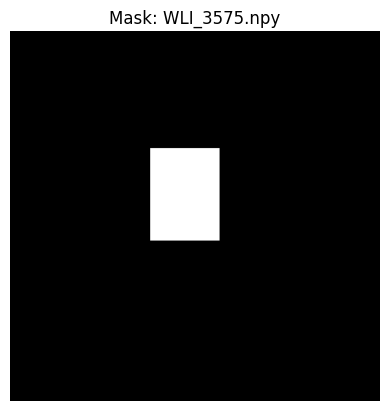

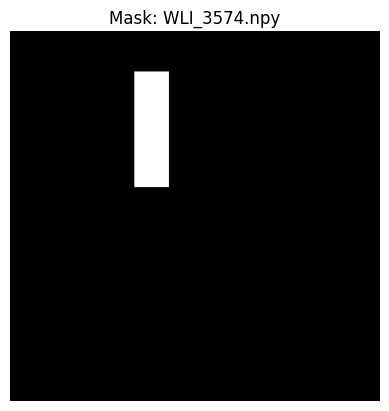

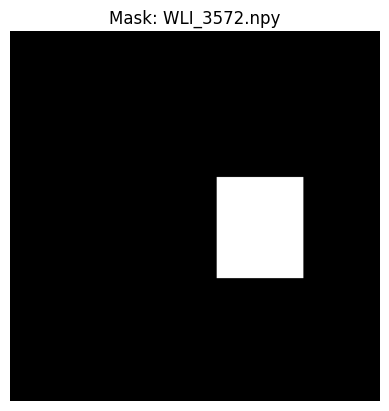

Mask file not found: WLI_3562.npy


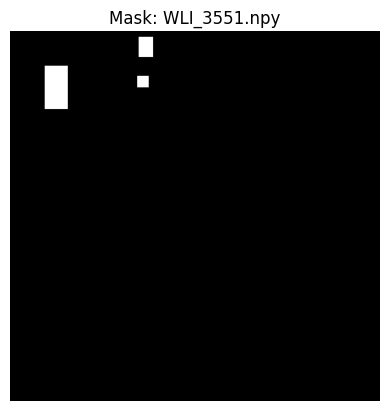

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the path to your .npy mask files
mask_dir = '/content/drive/MyDrive/Balanced_Dataset/deeplab/attention_masks/train'

# List of specific mask names you want to visualize
target_mask_names = [
    'WLI_3575.npy',  # Add '.npy' extension
    'WLI_3574.npy',
    'WLI_3572.npy',
    'WLI_3562.npy',
    'WLI_3551.npy'
]

# Get a list of all .npy files in the directory
mask_files = os.listdir(mask_dir)

# Check if there are any mask files
if not mask_files:
    print(f"No .npy mask files found in: {mask_dir}")
else:
    for target_mask_name in target_mask_names:
        if target_mask_name in mask_files:
            mask_file = os.path.join(mask_dir, target_mask_name)
            try:
                # Load the .npy file
                mask = np.load(mask_file)

                # Display the mask in grayscale
                plt.figure()
                plt.imshow(mask, cmap='gray')  # Use the 'gray' colormap for black and white
                plt.title(f"Mask: {target_mask_name}")
                plt.axis('off')  # Turn off axis labels and ticks
                plt.show()

            except Exception as e:
                print(f"Error loading or displaying {target_mask_name}: {e}")
        else:
            print(f"Mask file not found: {target_mask_name}")

Convert .npy attention masks to tensorized masks .pt

In [ ]:
import os
import numpy as np
import torch
from tqdm import tqdm

# Define base directory
base_dir = "/content/drive/MyDrive/Balanced_Dataset/"

# Define splits
splits = {
    "train": "deeplab/attention_masks/train",
    "val": "deeplab/attention_masks/val",
    "test": "deeplab/attention_masks/test"
}

# Directory for saving the tensorized masks
save_dir = os.path.join(base_dir, "deeplab/tensorized_attention_masks")
os.makedirs(save_dir, exist_ok=True)

def save_attention_masks_as_tensor(split_name, labels_folder):
    """
    Load attention masks from .npy, convert them to tensors, and save as .pt.
    """
    label_dir = os.path.join(base_dir, labels_folder)
    output_dir = os.path.join(save_dir, split_name)
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each .npy file
    for mask_file in tqdm(os.listdir(label_dir), desc=f"Processing {split_name} masks"):
        if not mask_file.endswith(".npy"):
            continue

        mask_path = os.path.join(label_dir, mask_file)

        # Load the .npy mask
        mask = np.load(mask_path)

        # Convert the mask to a tensor
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        # Save the tensor as .pt
        mask_tensor_path = os.path.join(output_dir, mask_file.replace(".npy", ".pt"))
        torch.save(mask_tensor, mask_tensor_path)

# Process all splits
for split_name, labels_folder in splits.items():
    save_attention_masks_as_tensor(split_name, labels_folder)


Processing test masks: 100%|██████████| 300/300 [00:06<00:00, 47.09it/s]


Convert images to tensors and save them


In [ ]:
import os
import torch
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

# Define base directory
base_dir = "/content/drive/MyDrive/Balanced_Dataset/"

# Define splits
splits = {
    "train": "yolo_dataset/images/train",
    "val": "yolo_dataset/images/val",
    "test": "yolo_dataset/images/test"
}

# Directory for saving the tensorized images
save_dir = os.path.join(base_dir, "deeplab/images")
os.makedirs(save_dir, exist_ok=True)

# Define transformation to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

def save_images_as_tensor(split_name, images_folder):
    """
    Load images, convert to tensors, and save as .pt.
    """
    images_dir = os.path.join(base_dir, images_folder)
    output_dir = os.path.join(save_dir, split_name)
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each image file
    for image_file in tqdm(os.listdir(images_dir), desc=f"Processing {split_name} images"):
        if not image_file.endswith(".jpg"):
            continue

        image_path = os.path.join(images_dir, image_file)

        # Load the image
        img = Image.open(image_path).convert("RGB")

        # Apply transformation (convert to tensor and normalize)
        img_tensor = transform(img)

        # Save the tensor as .pt
        tensor_path = os.path.join(output_dir, image_file.replace(".jpg", ".pt"))
        torch.save(img_tensor, tensor_path)

# Process all splits
for split_name, images_folder in splits.items():
    save_images_as_tensor(split_name, images_folder)


Processing test images: 100%|██████████| 300/300 [00:10<00:00, 28.38it/s]


Convert ground truth to tensors and save them


In [ ]:
import os
import torch
from tqdm import tqdm
from PIL import Image

# Directory paths
base_dir = "/content/drive/MyDrive/Balanced_Dataset/"
splits = {
    "train": "yolo_dataset/masks/train",
    "val": "yolo_dataset/masks/val",
    "test": "yolo_dataset/masks/test"
}

# Function to convert ground truth masks to tensors and save them
def save_ground_truth_masks_to_tensor(mask_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Loop through all mask files
    for mask_file in tqdm(os.listdir(mask_dir), desc=f"Processing masks in {mask_dir}"):
        if not mask_file.endswith("_mask.jpg"):
            continue

        # Load mask image
        mask_path = os.path.join(mask_dir, mask_file)
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale (1 channel)
        mask_tensor = torch.tensor(np.array(mask), dtype=torch.float32)  # Convert to tensor

        # Save tensor to .pt (PyTorch tensor format)
        mask_tensor_save_path = os.path.join(output_dir, mask_file.replace(".jpg", ".pt"))
        torch.save(mask_tensor, mask_tensor_save_path)

# Loop through splits to save ground truth masks
for split_name, labels_folder in splits.items():
    mask_dir = os.path.join(base_dir, labels_folder)
    output_dir = os.path.join(base_dir, f"deeplab/masks/{split_name}")
    save_ground_truth_masks_to_tensor(mask_dir, output_dir)


Processing masks in /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/masks/train: 100%|██████████| 2400/2400 [01:19<00:00, 30.01it/s]
Processing masks in /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/masks/val: 100%|██████████| 300/300 [00:10<00:00, 28.53it/s]
Processing masks in /content/drive/MyDrive/Balanced_Dataset/yolo_dataset/masks/test: 100%|██████████| 300/300 [00:08<00:00, 33.85it/s]


Feature Extraction Using EfficintNetB0

In [ ]:
# import torch
# import torchvision
# from torch.utils.data import Dataset, DataLoader
# import os
# import numpy as np
# from tqdm import tqdm

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Dataset class
# class FeatureExtractionDataset(Dataset):
#     def __init__(self, images_dir, attention_dir):
#         self.images_dir = images_dir
#         self.attention_dir = attention_dir
#         self.image_files = sorted(os.listdir(images_dir))  # Same name assumed

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.images_dir, self.image_files[idx])
#         attention_path = os.path.join(self.attention_dir, self.image_files[idx])

#         image = torch.load(img_path)  # Loaded as tensor
#         attention = torch.load(attention_path)  # Loaded as tensor

#         # If attention mask is 1-channel, expand dimensions
#         if attention.ndim == 2:
#             attention = attention.unsqueeze(0)  # (1, H, W)

#         # Concatenate along channel axis
#         x = torch.cat([image, attention], dim=0)  # (4, H, W)

#         return x, self.image_files[idx]

# # Load backbone
# from torchvision.models import efficientnet_b0

# backbone = efficientnet_b0(weights="IMAGENET1K_V1").features  # Only features part

# # Modify first conv to accept 4 channels
# old_conv = backbone[0][0]
# new_conv = torch.nn.Conv2d(
#     in_channels=4,
#     out_channels=old_conv.out_channels,
#     kernel_size=old_conv.kernel_size,
#     stride=old_conv.stride,
#     padding=old_conv.padding,
#     bias=old_conv.bias is not None
# )

# # Copy pretrained weights for first 3 channels
# with torch.no_grad():
#     new_conv.weight[:, :3, :, :] = old_conv.weight
#     new_conv.weight[:, 3:, :, :] = old_conv.weight[:, :1, :, :]  # Copy 1st channel for attention

# backbone[0][0] = new_conv

# backbone = backbone.to(device)
# backbone.eval()

# # Dataset paths
# datasets = {
#     'train': FeatureExtractionDataset('/content/drive/MyDrive/Balanced_Dataset/deeplab/images/train/', '/content/drive/MyDrive/Balanced_Dataset/deeplab/tensorized_attention_masks/train/'),
#     'val': FeatureExtractionDataset('/content/drive/MyDrive/Balanced_Dataset/deeplab/images/val/', '/content/drive/MyDrive/Balanced_Dataset/deeplab/tensorized_attention_masks/val/'),
#     'test': FeatureExtractionDataset('/content/drive/MyDrive/Balanced_Dataset/deeplab/images/test/', '/content/drive/MyDrive/Balanced_Dataset/deeplab/tensorized_attention_masks/test/')
# }

# # Output directory
# output_base = '/content/drive/MyDrive/Balanced_Dataset/deeplab/features/'

# for split, dataset in datasets.items():
#     print(f"Processing {split} dataset...")
#     loader = DataLoader(dataset, batch_size=1, shuffle=False)

#     save_dir = os.path.join(output_base, split)
#     os.makedirs(save_dir, exist_ok=True)

#     for inputs, filenames in tqdm(loader):
#         inputs = inputs.to(device)

#         with torch.no_grad():
#             features = backbone(inputs)  # EfficientNetB0 feature map

#         features = features.squeeze(0).cpu().numpy()  # Remove batch dimension

#         # Save as .npy
#         np.save(os.path.join(save_dir, filenames[0].replace('.pt', '.npy')), features)

# print("✅ Feature extraction completed.")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s] 


Processing train dataset...


100%|██████████| 2400/2400 [06:29<00:00,  6.16it/s]


Processing val dataset...


100%|██████████| 300/300 [02:25<00:00,  2.07it/s]


Processing test dataset...


100%|██████████| 300/300 [02:36<00:00,  1.92it/s]

✅ Feature extraction completed.


Building the Small CNN Decoder, Mini-UNet Decoder Architecture



In [ ]:
import torch
import torch.nn as nn

class MiniUNetDecoder(nn.Module):
    def __init__(self):
        super(MiniUNetDecoder, self).__init__()

        # Define layers based on the architecture table
        self.conv1 = nn.Conv2d(1280, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # Final output convolution to predict the binary mask (1 channel)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

        # Upsample layers
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 8 -> 16
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 16 -> 32
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 32 -> 64
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)  # 64 -> 256 (final size)

    def forward(self, x):
        # Pass through first layer (Conv -> BatchNorm -> ReLU)
        x = self.relu1(self.bn1(self.conv1(x)))

        # Upsample and pass through next layers
        x = self.upsample1(x)
        x = self.relu2(self.bn2(self.conv2(x)))

        x = self.upsample2(x)
        x = self.relu3(self.bn3(self.conv3(x)))

        x = self.upsample3(x)
        x = self.relu4(self.bn4(self.conv4(x)))

        # Upsample to the final size of the mask (e.g., 256x256)
        x = self.upsample4(x)

        # Final convolution layer to predict the mask (1 channel)
        x = self.final_conv(x)

        return x


Copying files to memory

In [ ]:
import os
import shutil

# Base dirs
deeplab_base_dir = '/content/drive/MyDrive/Balanced_Dataset/deeplab/'
cache_base_dir = '/content/cache/'

# splits
splits = ['train', 'val', 'test']

for split in splits:
    # Source paths
    feature_src = os.path.join(deeplab_base_dir, 'features', split)
    mask_src = os.path.join(deeplab_base_dir, 'masks', split)

    # Destination paths
    feature_dst = os.path.join(cache_base_dir, split, 'features')
    mask_dst = os.path.join(cache_base_dir, split, 'masks')

    os.makedirs(feature_dst, exist_ok=True)
    os.makedirs(mask_dst, exist_ok=True)

    # Copy
    shutil.copytree(feature_src, feature_dst, dirs_exist_ok=True)
    shutil.copytree(mask_src, mask_dst, dirs_exist_ok=True)

print("✅ Copied features and masks to /content/cache/")


✅ Copied features and masks to /content/cache/


Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class FeatureToMaskDataset(Dataset):
    def __init__(self, cache_dir, split):
        self.feature_dir = os.path.join(cache_dir, split, 'features')
        self.mask_dir = os.path.join(cache_dir, split, 'masks')
        self.files = sorted(os.listdir(self.feature_dir))  # Base filenames

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]

        # Load feature
        feature_path = os.path.join(self.feature_dir, file_name)
        feature = np.load(feature_path)  # (C, H, W)
        feature = torch.tensor(feature, dtype=torch.float32)

        # Load GT mask
        mask_path = os.path.join(self.mask_dir, file_name.replace('.npy', '_mask.pt'))
        mask = torch.load(mask_path)  # (1, H, W) or (H, W)
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)  # (1, H, W)

        return feature, mask


Data Loader

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
cache_dir = '/content/cache/'

train_dataset = FeatureToMaskDataset(cache_dir, 'train')
val_dataset = FeatureToMaskDataset(cache_dir, 'val')
test_dataset = FeatureToMaskDataset(cache_dir, 'test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("✅ Dataloaders ready!")


✅ Dataloaders ready!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MiniUNetDecoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=200.0):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight))

    def forward(self, inputs, targets):
        return self.bce_loss(inputs, targets)

def dice_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    smooth = 1e-6  # To avoid division by zero
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()


In [ ]:
from tqdm import tqdm


# Initialize
num_epochs = 20
criterion = WeightedBCELoss(pos_weight=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

save_path = '/content/drive/MyDrive/Balanced_Dataset/mini_unet_decoder_best.pth'
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_dice = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for features, masks in loop:
        features = features.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(features)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0

    loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for features, masks in loop:
            features = features.to(device)
            masks = masks.to(device)

            outputs = model(features)

            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    print(f"📢 Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved at {save_path} with Val Loss: {val_loss:.4f}")

print("🎯 Full Training Completed!")


KeyboardInterrupt: 

In [ ]:
# Reload best weights
model.load_state_dict(torch.load(save_path))
model.eval()
print("✅ Loaded Best Model for Testing")


✅ Loaded Best Model for Testing


In [ ]:
def calculate_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    smooth = 1e-6

    intersection = (preds * targets).sum(dim=(1,2,3))
    preds_sum = preds.sum(dim=(1,2,3))
    targets_sum = targets.sum(dim=(1,2,3))

    union = preds_sum + targets_sum - intersection

    dice = (2. * intersection + smooth) / (preds_sum + targets_sum + smooth)
    iou = (intersection + smooth) / (union + smooth)

    precision = (intersection + smooth) / (preds_sum + smooth)
    recall = (intersection + smooth) / (targets_sum + smooth)
    f1 = (2 * precision * recall) / (precision + recall + smooth)

    return dice.mean(), iou.mean(), precision.mean(), recall.mean(), f1.mean()


In [ ]:
test_dice = 0.0
test_iou = 0.0
test_precision = 0.0
test_recall = 0.0
test_f1 = 0.0

loop = tqdm(test_loader, desc="Testing", leave=False)

with torch.no_grad():
    for features, masks in loop:
        features = features.to(device)
        masks = masks.to(device)

        outputs = model(features)

        dice, iou, precision, recall, f1 = calculate_metrics(outputs, masks)

        test_dice += dice.item()
        test_iou += iou.item()
        test_precision += precision.item()
        test_recall += recall.item()
        test_f1 += f1.item()

num_batches = len(test_loader)

# Final Average Metrics
test_dice /= num_batches
test_iou /= num_batches
test_precision /= num_batches
test_recall /= num_batches
test_f1 /= num_batches

print("\n📊 Test Set Evaluation Metrics:")
print(f"Dice Score: {test_dice:.4f}")
print(f"IoU Score : {test_iou:.4f}")
print(f"Precision  : {test_precision:.4f}")
print(f"Recall     : {test_recall:.4f}")
print(f"F1 Score   : {test_f1:.4f}")



📊 Test Set Evaluation Metrics:
Dice Score: 1.7652
IoU Score : 53.7797
Precision  : 71.6365
Recall     : 0.9003
F1 Score   : 1.7652


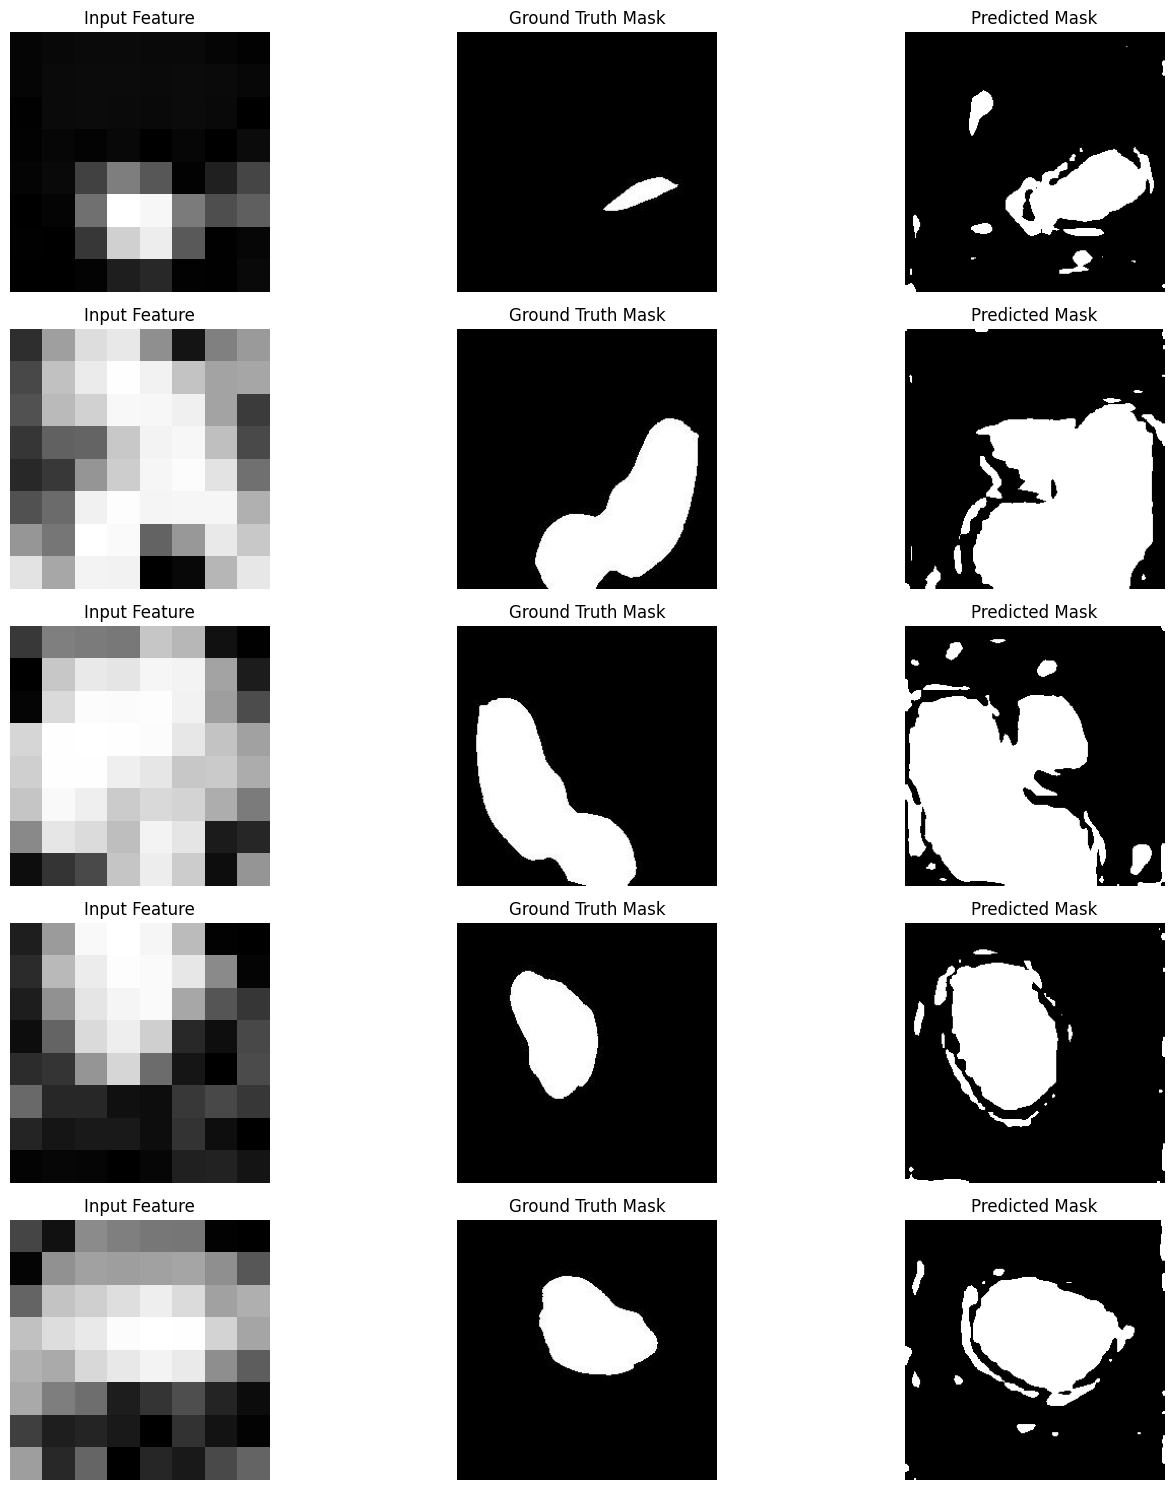

In [ ]:
import matplotlib.pyplot as plt

# Fetch a few samples from test set
num_samples_to_plot = 5

model.eval()

with torch.no_grad():
    samples = next(iter(test_loader))
    features, masks = samples
    features = features.to(device)
    masks = masks.to(device)

    preds = model(features)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

# Plotting
plt.figure(figsize=(15, num_samples_to_plot * 3))
for idx in range(num_samples_to_plot):
    # Original Image + Mask + Prediction
    plt.subplot(num_samples_to_plot, 3, idx*3 + 1)
    plt.imshow(features[idx,0].cpu(), cmap='gray')
    plt.title('Input Feature')
    plt.axis('off')

    plt.subplot(num_samples_to_plot, 3, idx*3 + 2)
    plt.imshow(masks[idx,0].cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(num_samples_to_plot, 3, idx*3 + 3)
    plt.imshow(preds[idx,0].cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os

def find_file(filename, features_folder):
  """Finds a file with the given filename in the features folder.

  Args:
    filename: The name of the file to search for.
    features_folder: The path to the features folder.

  Returns:
    The full path to the file if found, or None if not found.
  """
  for root, _, files in os.walk(features_folder):
    if filename in files:
      return os.path.join(root, filename)
  return None

# Example usage
features_folder = "/content/drive/MyDrive/Balanced_Dataset/deeplab/features/train"  # Replace with your actual path
filename_to_find = "LCI_46_aug7.npy"  # Replace with the filename you're looking for

file_path = find_file(filename_to_find, features_folder)

if file_path:
  print(f"File found at: {file_path}")
else:
  print(f"File '{filename_to_find}' not found in the features folder.")

File found at: /content/drive/MyDrive/Balanced_Dataset/deeplab/features/train/LCI_46_aug7.npy


Prints the different image sizes in a directory.

In [ ]:
import os
from PIL import Image

def print_image_sizes(directory):
    sizes = set()
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            filepath = os.path.join(directory, filename)
            try:
                with Image.open(filepath) as img:
                    sizes.add(img.size)
            except IOError:
                print(f"Error opening image: {filepath}")

    print("Different image sizes:")
    for size in sizes:
        print(size)

directory = '/content/drive/MyDrive/Balanced_Dataset/yolo_dataset/images/train'
print_image_sizes(directory)

Different image sizes:
(256, 256)


/deeplab/images/train/

/deeplab/images/val/

/deeplab/images/test/

/deeplab/masks/train/

/deeplab/masks/val/

/deeplab/masks/test/

/deeplab/tensorized_attention_masks/train/

/deeplab/tensorized_attention_masks/val/

/deeplab/tensorized_attention_masks/test/